In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D 

In [2]:
class LorenzSystem:
    def __init__(self, sigma, rho, beta, dt, initial = np.array([-7.45, -3.03, 0.01])):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta
        self.dt = dt
        self.state = initial

    def step(self, fx = 0, fy = 0, fz = 0):
        x, y, z = self.state
        xp = self.sigma * (y - x) + fx
        yp = x * (self.rho - z) - y + fy
        zp = x * y - self.beta * z + fz
        self.state += self.dt * np.array([xp, yp, zp])
        return self.state
    


class Reservoir:
    def __init__(self, n, m, mu, lam):
        self.n = n                  # Number of neurons in reservoir
        self.m = m                  # Number of dimensions of the system
        self.lam = lam              # Ridge regression coefficient
        self.r = 0.5 - np.random.rand(n)                        # Randomly initialize states of neurons
        self.Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)      # Randomly initialize Win matrix
        self.A = self.create_adjacency_matrix(n, mu)
        self.Wout = np.zeros((m,n))

    def create_adjacency_matrix(self, n, mu):
        A = sp.random(n, n, density=6/n, format='csr')
        A = A - 0.5 * np.sign(A.toarray())
        A = A * mu / np.abs(sp.linalg.eigs(A, k=1)[0])
        return sp.csr_matrix(A)
    
    def update(self, input):
        self.r = np.tanh(self.A.dot(self.r) + self.Win.dot(input) + 1)
        return self.r

In [3]:
def trainreservoir(sys : LorenzSystem, res : Reservoir, dt, ntraining, mf = 1):
    
    R = np.zeros((res.n, ntraining))
    f = np.zeros((res.m, ntraining))

    for t in range(ntraining):

        R[:, t] = res.r

        fx = mf * np.cos(0.05 * dt * t)
        fy = mf * np.sin(0.05 * dt * t)

        f[0, t] = fx
        f[1, t] = fy

        res.update(sys.state)
        sys.step(fx, fy)

        

    ## Finding Wout matrix using ridge regression
    res.Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + res.lam * np.eye(res.n)))

    return sys, res

In [10]:
def runsystem(sys : LorenzSystem, res : Reservoir, dt, ntest, dis, tau, alpha):

    #syspure = sys
    #sysnocontrol = sys

    # xpure = np.zeros((res.m, ntest))
    # xnocontrol = np.zeros((res.m, ntest))
    xcontrol = np.zeros((res.m, ntest))
    
    u = np.zeros(res.m)
    v = np.zeros(res.m)


    for t in range(ntest):
        
        ## First lorenz system has no disturbance
        #xpure[:, t] = syspure.step()

        ## Second system has disturbance but no control
        #gy = dis * sysnocontrol.state[0]
        #xnocontrol[:, t] = sysnocontrol.step(0, gy, 0)

        ## Third system has disturbance and delayed control
        gycontrol = dis * sys.state[0]
        u = res.Wout.dot(res.r)
        v = v + (dt / tau) * (u - v)
        xcontrol[:, t] = sys.step(0 - alpha * v[0], gycontrol - alpha * v[1], - alpha * v[2])
        res.update(sys.state)
    



    plt.figure()
    ax = plt.axes(projection = '3d')
    #ax.plot3D(xpure[0], xpure[1], xpure[2], 'r', linewidth = 0.3)
    #ax.plot3D(xnocontrol[0], xnocontrol[1], xnocontrol[2], 'b', linewidth = 0.1)
    ax.plot3D(xcontrol[0], xcontrol[1], xcontrol[2], 'g', linewidth = 0.1)
    plt.show()

    # plt.figure()
    # ax = plt.axes(projection = '3d')
    # ax.plot3D(xpure[0], xpure[1], xpure[2], 'r', linewidth = 0.1)
    # plt.show()

    # plt.figure()
    # ax = plt.axes(projection = '3d')
    # ax.plot3D(xnocontrol[0], xnocontrol[1], xnocontrol[2], 'b', linewidth = 0.1)
    # plt.show()

    # plt.figure()
    # ax = plt.axes(projection = '3d')
    # ax.plot3D(xcontrol[0], xcontrol[1], xcontrol[2], 'g', linewidth = 0.1)
    # plt.show()

    # plt.figure()
    # ax = plt.axes(projection = '3d')
    # ax.plot3D(xpure[0], xpure[1], xpure[2], 'r', linewidth = 0.1)
    # ax.plot3D(xcontrol[0], xcontrol[1], xcontrol[2], 'g', linewidth = 0.1)
    # plt.show()



    return sys, res



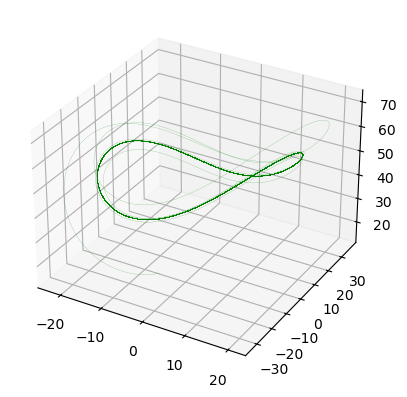

In [14]:
########################## Initializing all parameters ####################

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                    # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Control parameters
alpha = 100
tau = 10

## Simulation parameters
Ttraining = 100
dt = 0.002
ntraining = int(Ttraining / dt)
trainingtimes = np.linspace(0, Ttraining, ntraining + 1)

## Testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)



########################## Setting up and training #######################

## Setting up system and reservoir
sys = LorenzSystem(sigma, rho, beta, dt)
res = Reservoir(n, m, mu, lam)

## Training with forcing functions
sys, res = trainreservoir(sys, res, dt, ntraining)


########################## Testing   #####################################

dis = 20
sys, res = runsystem(sys, res, dt, ntest, dis, tau, alpha)



